Notebook purpose:

- Explain why leads drop at 12+ instead of 13+.

In [197]:
import sys

sys.path.append("/Users/fgu/dev/projects/mdb_eval")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import src.data.aggregators as agg
import src.data.make_data as md
import src.data.selectors as sl
import src.helpers.data as hd
import src.helpers.io as io

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Large drop in users with 12+ leads

Load analysis data

In [198]:
dfa = hd.read_analysis_data()
hd.inspect(dfa)

shape: (188,324, 34), users: 6739


,user_id,ym,ymn,month,txns_count,txns_volume,month_income,inflows,outflows,netflows,netflows_norm,inflows_norm,outflows_norm,has_pos_netflows,pos_netflows,user_reg_ym,t,tt,month_spend,age,is_female,region,is_urban,region_code,has_savings_account,has_current_account,generation,generation_code,prop_credit,dspend,dspend_count,dspend_mean,accounts_active,accounts_total
0,447820,2017-01,201701,1,139.0,8498.040039,2245.067383,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2018-07,0,-18,1562.160034,35.0,0.0,london,1.0,4,True,True,Millennials,3,0.0,905.159973,62,14.599355,1,5
1,447820,2017-02,201702,2,119.0,6800.819824,2245.067383,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2018-07,0,-17,2042.869995,35.0,0.0,london,1.0,4,True,True,Millennials,3,0.0,663.750000,49,13.545918,1,5


There is a very large drop in unique users between leads 11 and 12. (While the drop of user with 6 or more lags is very steep, it's plausible given that 1) we have selected users to have at least 5 lags, 2) we only have users who signed up after April 2018, and 3) we have data up to August 2020 only.) What's going on?

In [199]:
def tt_plot(df):
    """Plot number of unique users by time since app signup."""
    df.groupby("tt").user_id.nunique().loc[-20:20].plot(figsize=(10, 5), marker=".")

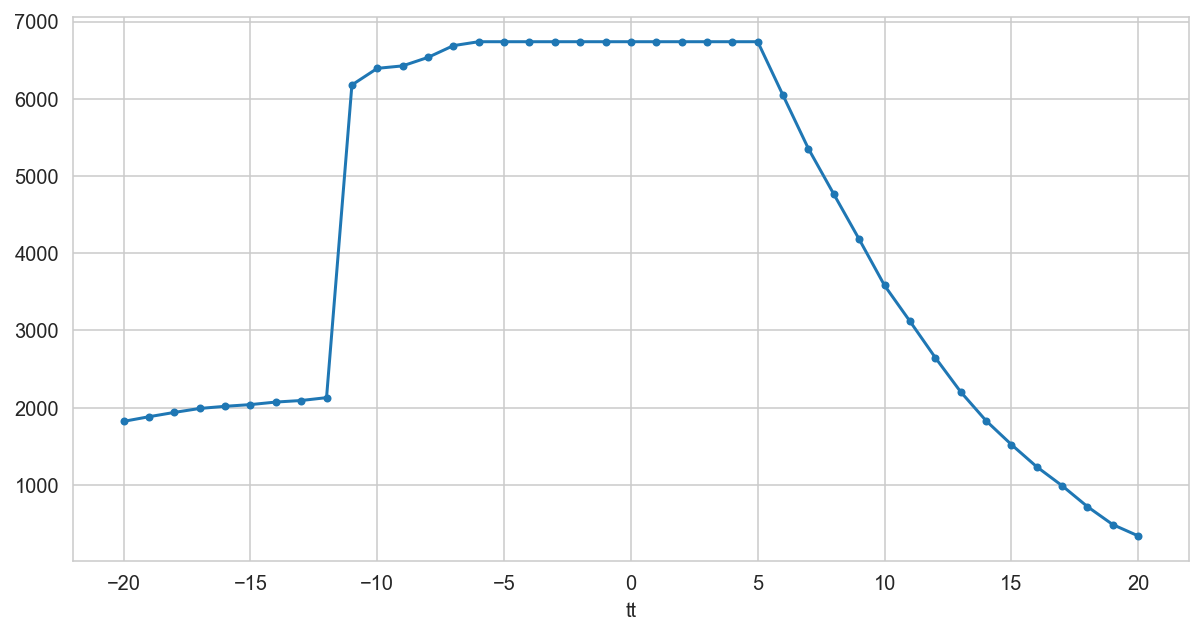

In [200]:
tt_plot(df)

### Replicate in txn data

As a first step, I want to replicate the drop with a txn data sample, to check that it isn't an artefact of the analysis data.

Load transaction data

In [5]:
dft = io.read_parquet("s3://3di-data-mdb/clean/samples/mdb_X11.parquet")
hd.inspect(dft)

shape: (6,653,551, 35), users: 2734


,date,user_id,amount,desc,merchant,tag_group,tag_spend,user_registration_date,account_created,account_id,account_last_refreshed,account_provider,account_type,birth_year,data_warehouse_date_created,data_warehouse_date_last_updated,id,is_debit,is_female,is_sa_flow,is_salary_pmt,is_urban,latest_balance,lsoa,merchant_business_line,msoa,postcode,region_name,salary_range,tag,tag_auto,tag_manual,tag_up,updated_flag,ym
0,2012-01-03,11,69.750000,david lloyd <mdbremoved>,david lloyd,spend,sports,2010-06-30,1900-01-01,303733,2014-07-24 11:05:00,lloyds,current,1954.0,2014-07-18,2017-08-15,80656,True,0.0,False,False,1.0,150.029999,e01015428,david lloyd,e02003207,bh15 4,south west,10k to 20k,hobbies,gym membership,no tag,gym membership,u,2012-01
1,2012-01-03,11,96.400002,sky digital xxxxxxxxxx9317,sky,spend,"entertainment, tv, media",2010-06-30,1900-01-01,303733,2014-07-24 11:05:00,lloyds,current,1954.0,2014-07-18,2017-08-15,80654,True,0.0,False,False,1.0,150.029999,e01015428,sky,e02003207,bh15 4,south west,10k to 20k,services,"entertainment, tv, media",no tag,media bundle,u,2012-01


Aggregate transaction data

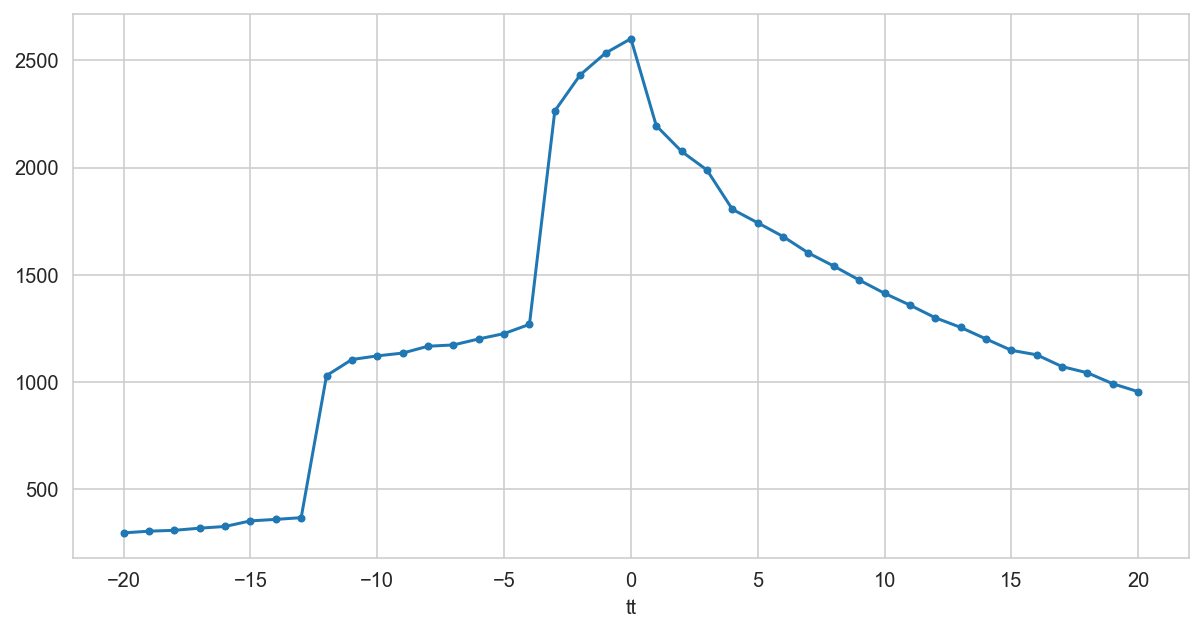

In [201]:
dfta = md.aggregate_data(dft)
tt_plot(dfta)

- The magnitude of the decline around 12 leads is similar to what we get with the analysis data (about two thirds of users are lost).

- But the drop happens at leads of 13+ months, rather than 12+ months as in the analysis data.

- Why is that? As we can see below, the drop moves from 13+ to 12+ once we drop the first and last months of data for each user. We do this because we are unlikely to observe all of their transactions in these months. A side effect of this is, of course, that we loose the outermost lead and lags for each user. Hence, users for whom we observe 12 leads in the raw data, we observe only 11 leads in the analysis data.

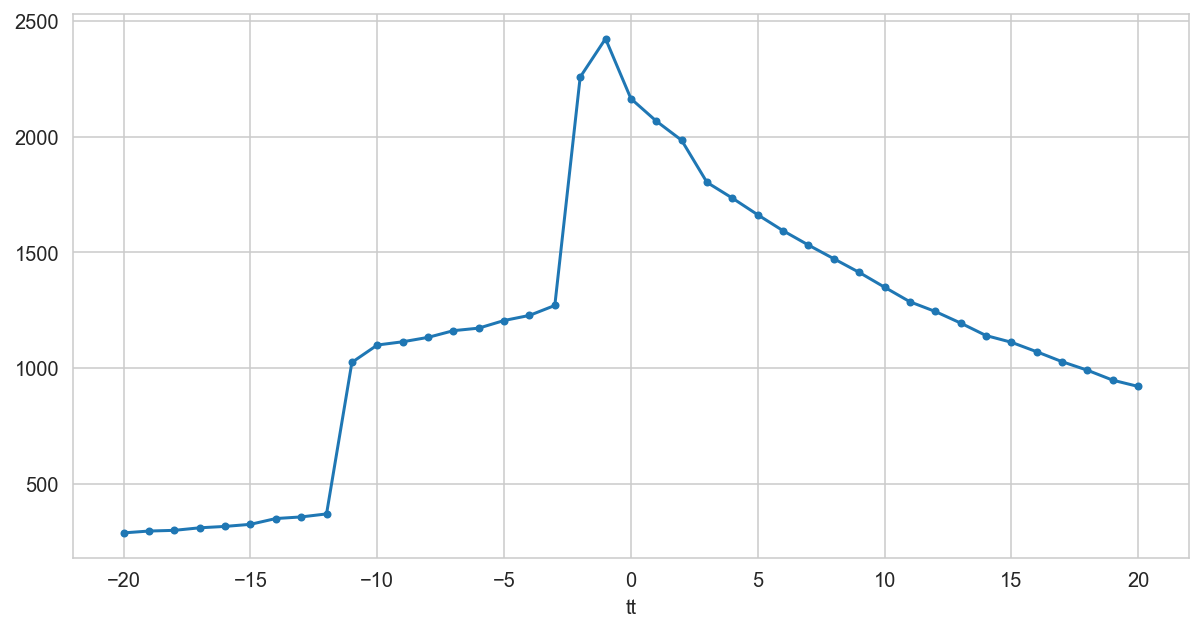

In [203]:
tt_plot(sl.drop_first_and_last_month(dfta))